# Analyze Temperature Evolution

This notebook plots the time series of daily maximum temperature by BA.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from datetime import timedelta


## Set the Directory Structure

In [2]:
# Identify the data input and output directories:
ba_weather_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_to_tell_data/'
ics_weather_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/Interconnection_Meteorology_Time_Series/'
ba_mapping_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/'
output_dir = '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/BA_Min_Max_Temperature_Time_Series/'
image_output_dir = '/Users/burl878/Documents/Code/code_repos/ntp_heat_wave_loads/plots/'


## Process the Historical Daily Minimum and Maximum Temperature Time Series


In [3]:
# Define a function to process the daily maximum and minimum temperature time series:
def process_daily_min_max_time_series(ba_weather_dir: str, ics_weather_dir: str, output_dir: str, ics_to_process: str):
    
    # Read in the BA-to-Interconnection mapping file:
    ba_df = pd.read_csv((ba_mapping_dir + 'BA_to_Interconnection_Mapping.csv'))
 
    # Subset to just the interconnection you want to process:
    ba_list = ba_df['BA_Code'].loc[ba_df['Interconnection'] == ics_to_process].unique()

    # Loop over the list of BAs in the interconnection:
    for i in range(len(ba_list)):
        
        # Loop over the years from the 1980 to 2019:
        for year in range(1980,2020,1):
            if year <= 2019:
               # Create the filename for the given BA and year combination:
               filename = (ba_weather_dir + 'historic/' + ba_list[i] + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv')
            else:
               # Create the filename for the given BA and year combination:
               filename = (ba_weather_dir + 'historic_2020_2022/' + ba_list[i] + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv') 
    
            # Read in the .csv file:
            met_df = pd.read_csv(filename)
    
            # Set the time variable as an index:
            met_df.index = pd.to_datetime(met_df['Time_UTC'])
        
            # Convert the temperature from Kelvin to Fahrenheit:
            met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
    
            # Compute the daily minimum and maximum temperature using resampling:
            temp_df = met_df.resample('D')['T2'].agg(['min', 'max']).reset_index()
        
            # Rename the variables for consistency:
            temp_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_Min', 'max': 'T2_Max'}, inplace=True)
        
            # Round off the min and max temperature variables:
            temp_df['T2_Min'] = temp_df['T2_Min'].round(2)
            temp_df['T2_Max'] = temp_df['T2_Max'].round(2)
        
            # Add a column with the year values to be used in grouping:
            temp_df['Year'] = temp_df['Day'].dt.strftime('%Y')
        
            # Set the day value as a datetime variable:
            temp_df['Day'] = pd.to_datetime(temp_df['Day'])
        
            # Compute the day of the year to be used in plotting:
            temp_df['Day_of_Year'] = temp_df['Day'].dt.dayofyear
        
            # Add in the BA code: 
            temp_df['BA'] = ba_list[i]
            
            # Reorder some of the variables:
            temp_df = temp_df[['BA', 'Day', 'Year', 'Day_of_Year', 'T2_Min', 'T2_Max']].copy()
        
            # Aggregate the output into a new dataframe:
            if year == 1980:
               ba_output_df = temp_df
            else:
               ba_output_df = pd.concat([ba_output_df, temp_df])
    
        # Aggregate the output into a new dataframe:
        if i == 0:
           ics_output_df = ba_output_df
        else:
           ics_output_df = pd.concat([ics_output_df, ba_output_df])
    
    # Loop over the years from the 1980 to 2019:
    for year in range(1980,2020,1):
                   
        # Read in the .csv file:
        met_df = pd.read_csv((ics_weather_dir + 'Interconnection_Meteorology_' + str(year) + '.csv'))
        
        # Subset to just the interconnection you want to process:
        met_df = met_df.loc[met_df['Interconnection'] == ics_to_process]
        
        # Set the time variable as an index:
        met_df.index = pd.to_datetime(met_df['Time_UTC'])
        
        # Convert the temperature from Kelvin to Fahrenheit:
        met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
    
        # Compute the daily minimum and maximum temperature using resampling:
        temp_df = met_df.resample('D')['T2'].agg(['min', 'max']).reset_index()
        
        # Rename the variables for consistency:
        temp_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_Min', 'max': 'T2_Max'}, inplace=True)
        
        # Round off the min and max temperature variables:
        temp_df['T2_Min'] = temp_df['T2_Min'].round(2)
        temp_df['T2_Max'] = temp_df['T2_Max'].round(2)
        
        # Add a column with the year values to be used in grouping:
        temp_df['Year'] = temp_df['Day'].dt.strftime('%Y')
        
        # Set the day value as a datetime variable:
        temp_df['Day'] = pd.to_datetime(temp_df['Day'])
        
        # Compute the day of the year to be used in plotting:
        temp_df['Day_of_Year'] = temp_df['Day'].dt.dayofyear
        
        # Add in the BA code: 
        temp_df['BA'] = ics_to_process
            
        # Reorder some of the variables:
        temp_df = temp_df[['BA', 'Day', 'Year', 'Day_of_Year', 'T2_Min', 'T2_Max']].copy()
    
        # Aggregate the output into a new dataframe:
        if year == 1980:
           ics_df = temp_df
        else:
           ics_df = pd.concat([ics_df, temp_df])
           
    # Concatenate the two primary dfs:
    ics_output_df = pd.concat([ics_output_df, ics_df])
    
    # Write out the dataframe to a .csv file:
    ics_output_df.to_csv((os.path.join(output_dir + ics_to_process + '_Min_Max_Temperature_1980_to_2019.csv')), sep=',', index=False)
    
    return ics_output_df 


In [4]:
ics_output_df = process_daily_min_max_time_series(ba_weather_dir = ba_weather_dir, 
                                                  ics_weather_dir = ics_weather_dir, 
                                                  output_dir = output_dir, 
                                                  ics_to_process = 'ERCOT')

ics_output_df


,BA,Day,Year,Day_of_Year,T2_Min,T2_Max
0,ERCO,1980-01-01,1980,1,32.41,57.67
1,ERCO,1980-01-02,1980,2,36.75,61.65
2,ERCO,1980-01-03,1980,3,47.17,56.53
3,ERCO,1980-01-04,1980,4,32.04,51.57
4,ERCO,1980-01-05,1980,5,32.63,56.07
...,...,...,...,...,...,...
360,ERCOT,2019-12-27,2019,361,54.21,67.89
361,ERCOT,2019-12-28,2019,362,57.97,69.91
362,ERCOT,2019-12-29,2019,363,51.13,64.38
363,ERCOT,2019-12-30,2019,364,33.96,56.55


In [5]:
# Define a function to compute the mean temperature as a function of time of day and day of year:
def process_average_temperature_time_series(ba_to_process: str, ba_weather_dir: str):
    
    # Loop over the years from the 1980 to 2019:
    for year in range(1980,2020,1):
        if year <= 2019:
           # Create the filename for the given BA and year combination:
           filename = (ba_weather_dir + 'historic/' + ba_to_process + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv')
        else:
           # Create the filename for the given BA and year combination:
           filename = (ba_weather_dir + 'historic_2020_2022/' + ba_to_process + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv') 
    
        # Read in the .csv file:
        met_df = pd.read_csv(filename)
    
        # Set the time variable as an index:
        met_df['Time_UTC'] = pd.to_datetime(met_df['Time_UTC'])
        
        # Convert the temperature from Kelvin to Fahrenheit:
        met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
    
        # Compute the day and hour of the year to be used in averaging:
        met_df['Day_of_Year'] = met_df['Time_UTC'].dt.dayofyear
        
        # Add a column with the year values to be used in grouping:
        met_df['Hour_of_Day'] = met_df['Time_UTC'].dt.hour
            
        # Only keep the variables we need:
        met_df = met_df[['Time_UTC', 'Day_of_Year', 'Hour_of_Day', 'T2']].copy()
        
        # Aggregate the output into a new dataframe:
        if year == 1980:
           ba_output_df = met_df
        else:
           ba_output_df = pd.concat([ba_output_df, met_df])
    
    # Compute the mean temperature as a function of time of day and day of year:
    ba_output_df['Mean_T2'] = ba_output_df.groupby(['Day_of_Year', 'Hour_of_Day'])['T2'].transform('mean').round(2)
    
    return ba_output_df


In [6]:
output_df = process_average_temperature_time_series(ba_to_process = 'LDWP', ba_weather_dir = ba_weather_dir)

output_df


,Time_UTC,Day_of_Year,Hour_of_Day,T2,Mean_T2
0,1980-01-01 00:00:00,1,0,58.046,53.79
1,1980-01-01 01:00:00,1,1,55.742,49.70
2,1980-01-01 02:00:00,1,2,54.392,48.42
3,1980-01-01 03:00:00,1,3,53.600,47.74
4,1980-01-01 04:00:00,1,4,53.024,47.25
...,...,...,...,...,...
8755,2019-12-31 19:00:00,365,19,53.996,55.05
8756,2019-12-31 20:00:00,365,20,55.166,56.16
8757,2019-12-31 21:00:00,365,21,55.580,56.79
8758,2019-12-31 22:00:00,365,22,55.364,56.85


## Make the Summer Temperature Plot


In [7]:
# Define a function to plot the annual mean and maximum temperature time series:
def plot_year_temperature_highlight(ba_weather_dir: str, ics_weather_dir: str, output_dir: str, ics_to_process: str, 
                                    image_output_dir: str, image_resolution: int, save_images=False):
    
    # Check to see if the aggregate file exist and if not then create it:
    if os.path.exists((os.path.join(output_dir + ics_to_process + '_Min_Max_Temperature_1980_to_2019.csv'))) == False:
       ics_output_df = process_daily_min_max_time_series(ba_weather_dir = ba_weather_dir, 
                                                         ics_weather_dir = ics_weather_dir, 
                                                         output_dir = output_dir, 
                                                         ics_to_process = ics_to_process)
    else:
       # Read in the aggregate file:
       ics_output_df = pd.read_csv((os.path.join(output_dir + ics_to_process + '_Min_Max_Temperature_1980_to_2019.csv')))
      
    # Compute the mean T2 max and mean as a function of day of year:
    ics_output_df['Mean_T2_Min'] =  ics_output_df.groupby(['BA','Day_of_Year'])['T2_Min'].transform('mean')
    ics_output_df['Mean_T2_Max'] =  ics_output_df.groupby(['BA','Day_of_Year'])['T2_Max'].transform('mean')
    
    # Subset to just the data for the interconnection and BA you want to plot:
    ics_df = ics_output_df.loc[ics_output_df['BA'] == ics_to_process]
    
    # Pull out the year you want to highlight:
    ics_2015_df = ics_df.loc[ics_df['Year'] == 2015]
    ics_2018_df = ics_df.loc[ics_df['Year'] == 2018]
    
    # Make the plot:
    plt.figure(figsize=(20, 10))
    plt.rcParams['font.size'] = 24
    
    plt.fill_between([176, 176, 183, 183], [57, 102, 102, 57], color='blue', alpha=0.15)
    plt.fill_between([203, 203, 209, 209], [57, 102, 102, 57], color='red', alpha=0.15)
    plt.scatter(ics_df['Day_of_Year'], ics_df['T2_Max'], 25, 'gray', label='1980-2019')
    plt.scatter(ics_df['Day_of_Year'], ics_df['Mean_T2_Max'], 25, 'black', label='1980-2019 Mean')
    plt.scatter(ics_df['Day_of_Year'], ics_df['Mean_T2_Max'], 75, 'black')
    plt.scatter(ics_2015_df['Day_of_Year'], ics_2015_df['T2_Max'], 25, 'b', label='2015')
    plt.scatter(ics_2015_df['Day_of_Year'], ics_2015_df['T2_Max'], 75, 'b')
    plt.plot(ics_2015_df['Day_of_Year'], ics_2015_df['T2_Max'], 'b-', linewidth=3)
    plt.scatter(ics_2018_df['Day_of_Year'], ics_2018_df['T2_Max'], 25, 'r', label='2018')
    plt.scatter(ics_2018_df['Day_of_Year'], ics_2018_df['T2_Max'], 75, 'r')
    plt.plot(ics_2018_df['Day_of_Year'], ics_2018_df['T2_Max'], 'r-', linewidth=3)
    plt.xlim([152, 244])
    plt.xticks([152, 166, 182, 196, 213, 227, 244], ['1-Jun', '15-Jun', '1-Jul', '15-Jul', '1-Aug', '15-Aug', '1-Sep'])
    plt.ylim([60, 100])
    plt.legend(loc='lower right', prop={'size': 24})
    plt.ylabel('Daily Maximum Temperature [$^\circ$F]')
    plt.title(('Temperature in the Western United States'))

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, (ics_to_process + '_Temperature_Evolution.png')), 
                   dpi=image_resolution, bbox_inches='tight', facecolor='white')
        

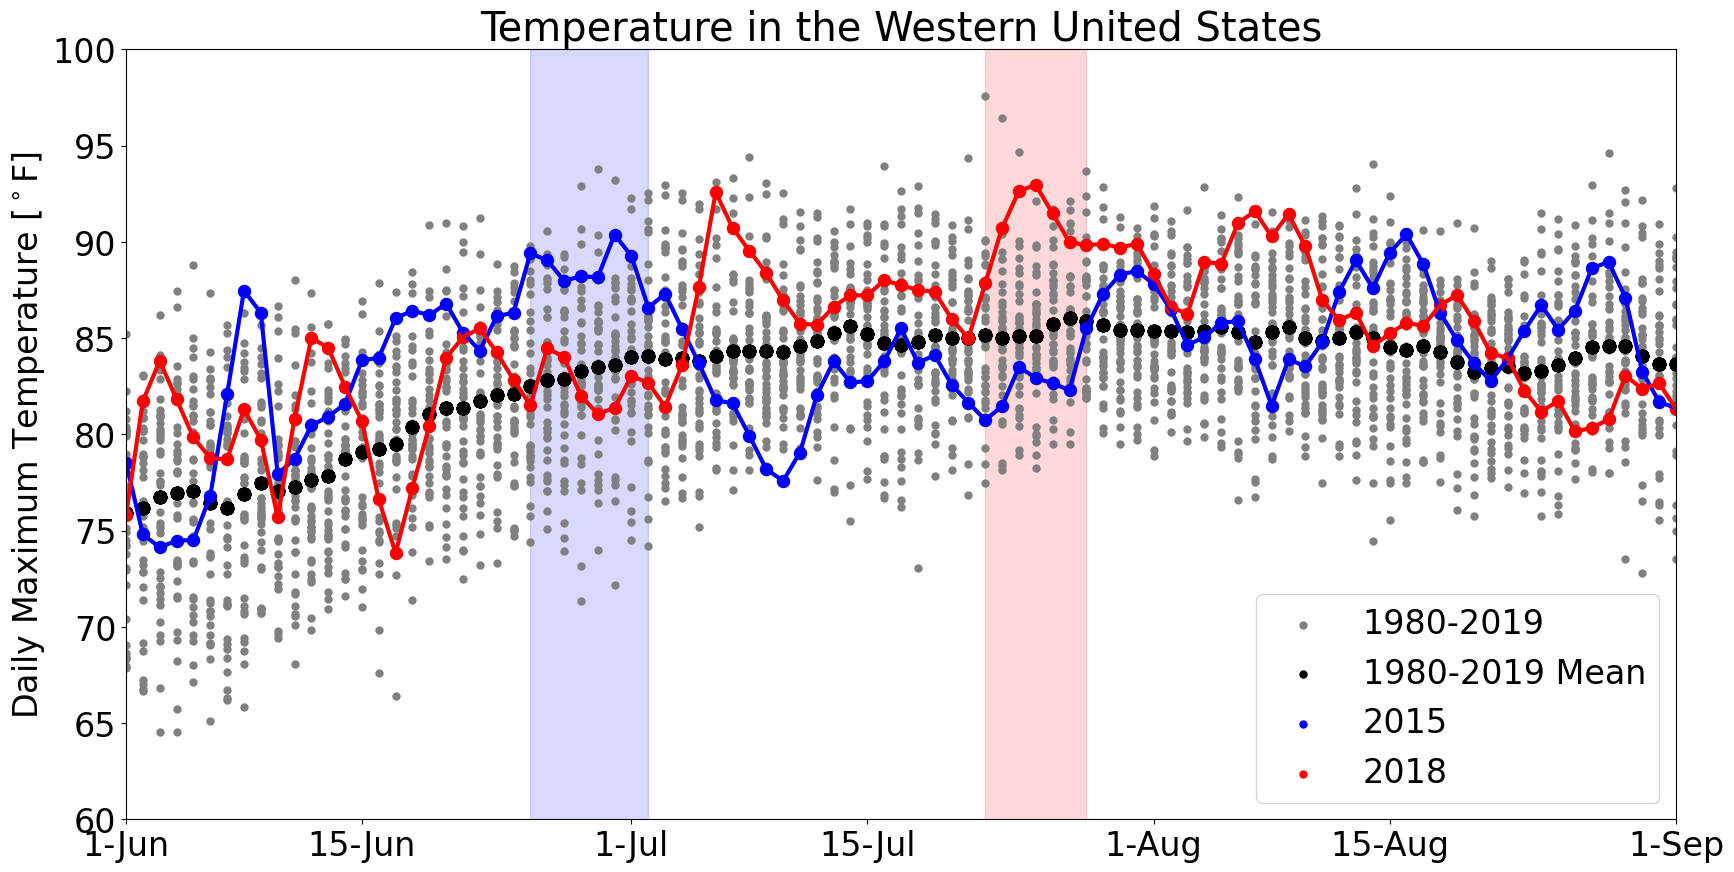

In [8]:
plot_year_temperature_highlight(ba_weather_dir = ba_weather_dir, 
                                ics_weather_dir = ics_weather_dir, 
                                output_dir = output_dir, 
                                ics_to_process = 'WECC',
                                image_output_dir = image_output_dir, 
                                image_resolution = 300, 
                                save_images = True)


## Plot the Change in Maximum Temperatures During the 2015 and 2018 Heat Waves


In [53]:
# Define a function to plot change in maximum temperature during the heat waves
def plot_maximum_temperature_change(ba_weather_dir: str, ba_mapping_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in BA-to-interconnection mapping file:
    ba_mapping = pd.read_csv((ba_mapping_dir + 'BA_to_Interconnection_Mapping.csv'))
    
    # Subset to just the list of BAs in the WECC:
    ba_mapping = ba_mapping.loc[(ba_mapping['Interconnection'] == 'WECC')]
    
    # Extract a list of all of the BAs in WECC:
    bas = ba_mapping['BA_Code'].unique()
    
    # Loop over the years
    for year in [2015, 2018, 2055, 2058]:
        # Set the heat wave start and end date in days of the year format:
        if year == 2015 or year == 2055:
           start_day = 176
           end_day = 183
        if year == 2018 or year == 2058:
           start_day = 203
           end_day = 209
        
        # Initiate a counter and empty dataframe to store the results:
        counter = 0;
        temp_df = pd.DataFrame()
        
        # Loop over the BAs and process their maximum temperature during the heat wave period:
        for i in range(len(bas)):
            # Iterate the counter by one:
            counter = counter + 1
            
            # Create the filename for the given BA and year combination:
            if year <= 2019:
               filename = (ba_weather_dir + 'historic/' + bas[i] + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv')
            else:
               filename = (ba_weather_dir + 'rcp85hotter_ssp5/' + bas[i] + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv')
        
            # Read in the .csv file:
            met_df = pd.read_csv(filename)
    
            # Set the time as a datetime variable:
            met_df['Time_UTC'] = pd.to_datetime(met_df['Time_UTC'])
        
            # Convert the temperature from Kelvin to Fahrenheit:
            met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
    
            # Compute the day of the year to be used in plotting:
            met_df['Day_of_Year'] = met_df['Time_UTC'].dt.dayofyear
        
            # Subset to just the heat wave period:
            met_df = met_df.loc[(met_df['Day_of_Year'] >= start_day) & (met_df['Day_of_Year'] <= end_day)]
  
            # Put the output in a new dataframe:
            temp_df.loc[counter, 'BA'] = bas[i]
            if year == 2015:
               temp_df.loc[counter, 'Max_2015_T2_F'] = (met_df['T2'].max()).round(2)
            if year == 2018:
               temp_df.loc[counter, 'Max_2018_T2_F'] = (met_df['T2'].max()).round(2)
            if year == 2055:
               temp_df.loc[counter, 'Max_2055_T2_F'] = (met_df['T2'].max()).round(2)
            if year == 2058:
               temp_df.loc[counter, 'Max_2058_T2_F'] = (met_df['T2'].max()).round(2)
      
            # Clean up and move to the next BA:
            del filename, met_df
    
        if year == 2015:
           # Assign the output_df as the temp_df:  
           output_df = temp_df
        else:
           # Merge the output_df and temp_df dataframes based on common BA names:
           output_df = output_df.merge(temp_df, on=['BA'])
    
        # Clean up and move to the next year:
        del temp_df
    
    # Calculate the mean change in maximum temperature for both events:
    print('Mean Impact in 2015 = ' + str((output_df['Max_2055_T2_F'] - output_df['Max_2015_T2_F']).mean().round(2)) + ' F')
    print('Mean Impact in 2018 = ' + str((output_df['Max_2058_T2_F'] - output_df['Max_2018_T2_F']).mean().round(2)) + ' F')
    
    # Define the 1:1 line:
    one_to_one = np.arange(80, 116, 1)
    
    # Make the plot:
    plt.figure(figsize=(20, 10))
    plt.rcParams['font.size'] = 15
    
    plt.subplot(121)
    plt.scatter(output_df['Max_2015_T2_F'], output_df['Max_2055_T2_F'], s=75, c='blue', label='BA Maximum Temperature')
    plt.plot(one_to_one,one_to_one,'k', linewidth=3, label = '1:1')
    plt.plot(one_to_one, (one_to_one + 5), 'k', linewidth=3, linestyle='--', label = '1:1 + 5$^\circ$F')
    plt.plot(one_to_one, (one_to_one + 10), 'k', linewidth=3, linestyle=':', label = '1:1 + 10$^\circ$F')
    plt.legend()
    plt.xlim(80, 115)
    plt.ylim(80, 115)
    plt.xlabel('Historical Heat Wave Maximum Temperature [$^\circ$F]')
    plt.ylabel('Projected Heat Wave Maximum Temperature [$^\circ$F]')
    plt.title('Climate Change Impact on 2015 NTP Heat Wave')
    
    plt.subplot(122)
    plt.scatter(output_df['Max_2018_T2_F'], output_df['Max_2058_T2_F'], s=75, c='red', label='BA Maximum Temperature')
    plt.plot(one_to_one,one_to_one,'k', linewidth=3, label = '1:1')
    plt.plot(one_to_one, (one_to_one + 5), 'k', linewidth=3, linestyle='--', label = '1:1 + 5$^\circ$F')
    plt.plot(one_to_one, (one_to_one + 10), 'k', linewidth=3, linestyle=':', label = '1:1 + 10$^\circ$F')
    plt.legend()
    plt.xlim(80, 115)
    plt.ylim(80, 115)
    plt.xlabel('Historical Heat Wave Maximum Temperature [$^\circ$F]')
    plt.ylabel('Projected Heat Wave Maximum Temperature [$^\circ$F]')
    plt.title('Climate Change Impact on 2018 NTP Heat Wave')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, ('Temperature_Change.png')), 
                   dpi=image_resolution, bbox_inches='tight', facecolor='white')
    
    return output_df


Mean Impact in 2015 = 5.55 F
Mean Impact in 2018 = 6.58 F


,BA,Max_2015_T2_F,Max_2018_T2_F,Max_2055_T2_F,Max_2058_T2_F
0,AVA,101.53,90.07,107.58,98.64
1,AZPS,104.43,108.99,109.24,115.30
2,BANC,106.43,106.05,111.97,110.79
3,BPAT,88.97,84.09,93.97,90.57
4,CHPD,86.40,81.99,90.84,88.63
5,CISO,90.77,94.78,95.85,99.34
6,DOPD,97.48,87.58,106.95,98.85
7,EPE,99.23,102.67,104.50,107.85
8,GCPD,104.14,93.04,110.77,101.23
9,IID,94.87,102.22,99.43,106.59


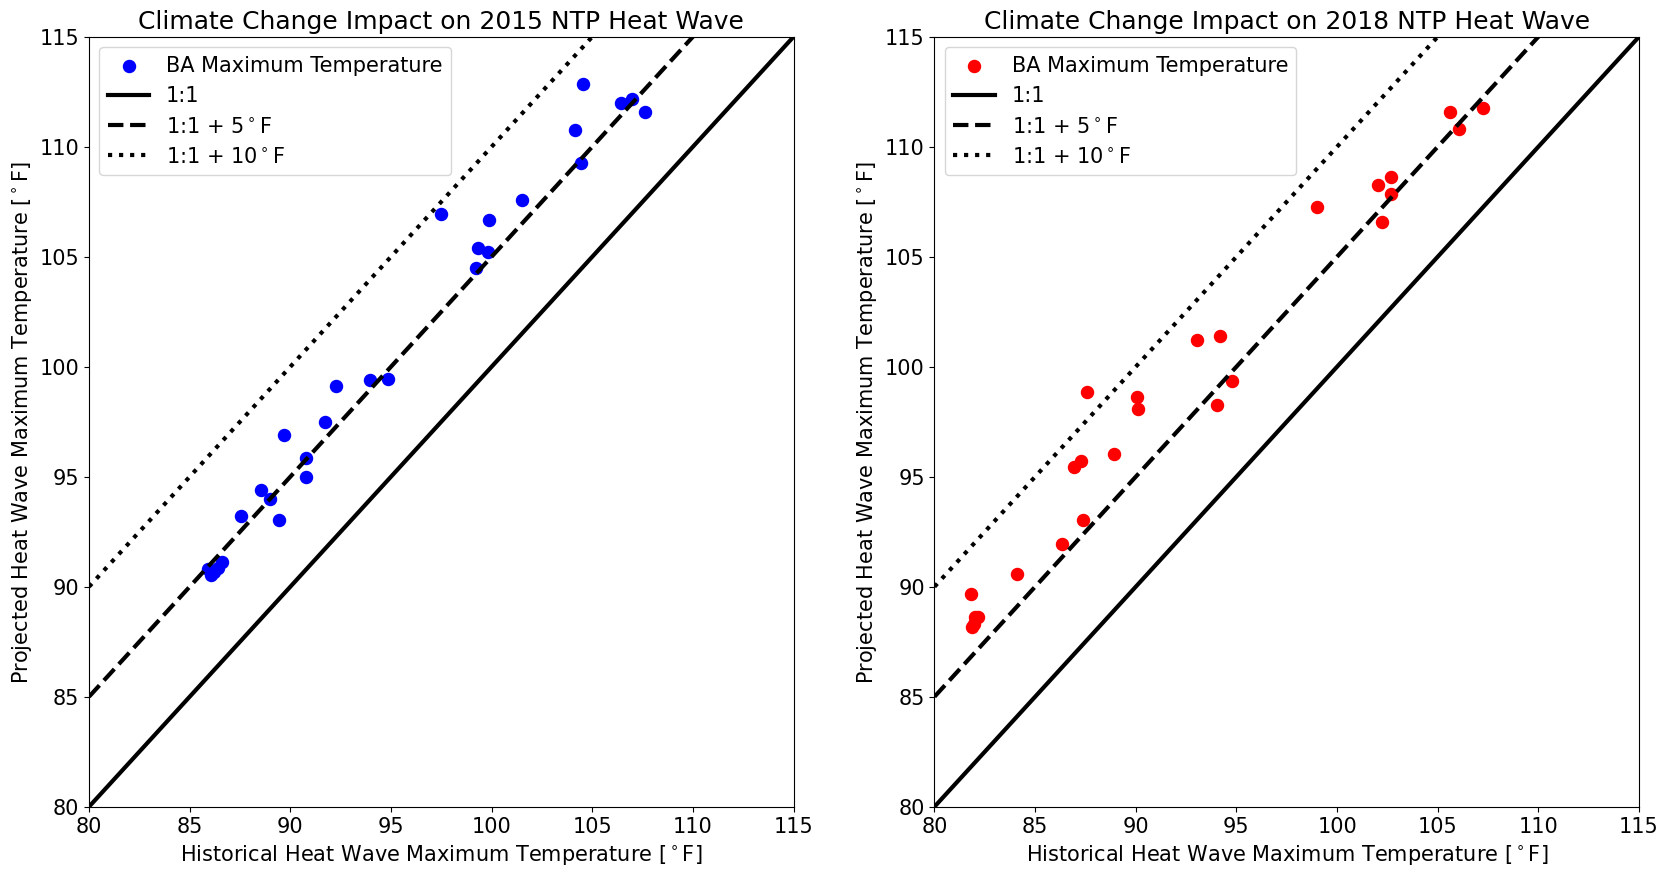

In [54]:
output_df = plot_maximum_temperature_change(ba_weather_dir = ba_weather_dir, 
                                            ba_mapping_dir = ba_mapping_dir,
                                            image_output_dir = image_output_dir, 
                                            image_resolution = 300, 
                                            save_images = True)

output_df
